# MLP Project – Predicting Purchase Value from Session Data

In [61]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


**Importing necessary libraries**

In [62]:
import pandas as pd
import numpy as np
import warnings

In [63]:
# Importing the training and testing dataset into df and dft
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
dft = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

# Setting option to display all the columns
pd.set_option('display.max_columns', None)

# To avoid warnings
warnings.filterwarnings("ignore")
df

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,61421,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not available in demo dataset,Washington,youtube.com,1,not available in demo dataset,1500100799,Windows,Northern America,referral,NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Redmond,NaN,Seattle-Tacoma WA,1.0,8,not available in demo dataset,/intl/hr/yt/about/,1.0,20170714,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,72287,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1495262065,Macintosh,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1.0,8,not available in demo dataset,NaN,1.0,20170519,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,25180,(not set),not available in demo dataset,domain1,0,not available in demo dataset,2,not available in demo dataset,Lombardy,google,1,not available in demo dataset,1508510328,Windows,Southern Europe,organic,NaN,not available in demo dataset,Italy,not available in demo dataset,NaN,Not Socially Engaged,Milan,NaN,(not set),6.0,8,not available in demo dataset,NaN,NaN,20171020,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,41295,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,youtube.com,1,not available in demo dataset,1483431838,Windows,Eastern Asia,referral,NaN,not available in demo dataset,Japan,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1.0,8,not available in demo dataset,/yt/about/ja/,1.0,20170103,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,113697,(not set),not available in demo dataset,domain1,0,not available 

In [64]:
null_cols = [
    'totals.visits', 'browserMajor', 'device.browserSize', 'device.screenResolution',
    'screenSize', 'device.language', 'device.screenColors', 'device.mobileDeviceModel',
    'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName',
    'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.networkLocation',
    'locationZone', 'socialEngagementType', 'device.browserVersion'
]
print(f"{'Feature':35s}   {'Value':32s} {' Normalized Value'}")
for col in null_cols:
    vc = df[col].value_counts(normalize=True)
    if len(vc) == 1:
        val = vc.index[0]
        prop = vc.iloc[0]
        print(f"{col:35s} -> {str(val):32s} ({prop:.2f})")


Feature                               Value                             Normalized Value
totals.visits                       -> 1                                (1.00)
browserMajor                        -> not available in demo dataset    (1.00)
device.browserSize                  -> not available in demo dataset    (1.00)
device.screenResolution             -> not available in demo dataset    (1.00)
screenSize                          -> medium                           (1.00)
device.language                     -> not available in demo dataset    (1.00)
device.screenColors                 -> not available in demo dataset    (1.00)
device.mobileDeviceModel            -> not available in demo dataset    (1.00)
device.mobileDeviceBranding         -> not available in demo dataset    (1.00)
device.mobileInputSelector          -> not available in demo dataset    (1.00)
device.mobileDeviceMarketingName    -> not available in demo dataset    (1.00)
device.operatingSystemVersion       -> not

Most of these features have only one unique value across the dataset, as shown in the output. These provide no useful variance for model training and can be safely dropped.

In [65]:
for col in null_cols:
    df = df.drop(col, axis=1)
    dft=dft.drop(col, axis=1)

Dropping the above-mentioned columns from both training and test sets to clean the dataset and reduce noise.

In [66]:
df=df.drop('userId',axis=1)
dft=dft.drop('userId',axis=1)
df=df.drop('sessionId',axis=1)
dft=dft.drop('sessionId',axis=1)

Removed userId and sessionId since they are identifiers and don't contribute any meaningful signal to the prediction task.

# Identifying and Handling Missing Values 

In [67]:
null_values=df.isnull().sum()
null_values[null_values>0]

trafficSource.isTrueDirect                       73133
trafficSource.adContent                         113060
trafficSource.keyword                            71861
trafficSource.adwordsClickInfo.slot             111742
trafficSource.adwordsClickInfo.isVideoAd        111742
trafficSource.adwordsClickInfo.adNetworkType    111742
trafficSource.adwordsClickInfo.page             111742
pageViews                                            8
trafficSource.referralPath                       73309
totals.bounces                                   68875
new_visits                                       35505
dtype: int64

Removing features with more number of null values (>50%)

In [68]:
null_cols=[
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.page'
]
for col in null_cols:
    df = df.drop(col, axis=1)
    dft=dft.drop(col, axis=1)

In [69]:
cols=['trafficSource.campaign',
       'trafficSource.keyword',
       'geoNetwork.metro']
print(f"{'Feature_Name':30s}{'Top Value':30s}","Normalized value")
for col in cols:
    print(f"{col:30s}{df[col].value_counts(normalize=True).index[0]:30s}",df[col].value_counts(normalize=True).iloc[0])

Feature_Name                  Top Value                      Normalized value
trafficSource.campaign        (not set)                      0.9505011937288296
trafficSource.keyword         (not provided)                 0.8846066754223088
geoNetwork.metro              not available in demo dataset  0.5183282624996768


Since these columns are dominated by a single unknown value, they are not informative. We will remove them.

In [70]:
for col in cols:
    df = df.drop(col, axis=1)
    dft=dft.drop(col, axis=1)

In [71]:
df.isnull().sum()

trafficSource.isTrueDirect    73133
purchaseValue                     0
browser                           0
geoCluster                        0
geoNetwork.networkDomain          0
gclIdPresent                      0
sessionNumber                     0
geoNetwork.region                 0
trafficSource                     0
os                                0
geoNetwork.subContinent           0
trafficSource.medium              0
locationCountry                   0
geoNetwork.city                   0
pageViews                         8
trafficSource.referralPath    73309
totals.bounces                68875
date                              0
deviceType                        0
userChannel                       0
totalHits                         0
sessionStart                      0
geoNetwork.continent              0
device.isMobile                   0
new_visits                    35505
dtype: int64

These will be handled after train_test_split

**Feature Engineering** for the 'sessionStart' feature

In [72]:
df['sessionStart_dt'] = pd.to_datetime(df['sessionStart'], unit='s')
df['sessionStart_dt']

0        2017-07-15 06:39:59
1        2017-05-20 06:34:25
2        2017-10-20 14:38:48
3        2017-01-03 08:23:58
4        2016-10-07 01:43:53
                 ...        
116018   2017-07-17 19:06:42
116019   2016-11-08 16:55:50
116020   2016-08-05 08:03:36
116021   2017-10-02 14:08:17
116022   2017-07-31 04:15:32
Name: sessionStart_dt, Length: 116023, dtype: datetime64[ns]

Converting the session start timestamp to datetime format.

In [73]:
df['hour'] = df['sessionStart_dt'].dt.hour
df['dayofweek'] = df['sessionStart_dt'].dt.dayofweek
df['month'] = df['sessionStart_dt'].dt.month
df.drop(columns=['sessionStart', 'sessionStart_dt'], inplace=True)

dft['sessionStart_dt'] = pd.to_datetime(dft['sessionStart'], unit='s')
dft['hour'] = dft['sessionStart_dt'].dt.hour
dft['dayofweek'] = dft['sessionStart_dt'].dt.dayofweek  # 0=Monday
dft['month'] = dft['sessionStart_dt'].dt.month
dft.drop(columns=['sessionStart', 'sessionStart_dt'], inplace=True)

Correlation matrix:
                purchaseValue  pageViews  totalHits
purchaseValue       1.000000   0.248454   0.251651
pageViews           0.248454   1.000000   0.986250
totalHits           0.251651   0.986250   1.000000


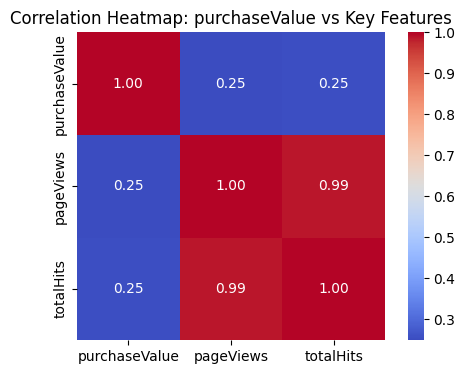

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
cols_to_check = ['purchaseValue', 'pageViews', 'totalHits']
corr_matrix = df[cols_to_check].corr()

# Display correlation coefficients
print("Correlation matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap: purchaseValue vs Key Features")
plt.show()


Correlation Analysis with Numerical columns and Target variable

Target Variable Analysis

In [75]:
df['purchaseValue'].value_counts(normalize=True)

purchaseValue
0.0            0.793274
16990000.0     0.003835
18990000.0     0.002827
33590000.0     0.002655
19990000.0     0.002482
                 ...   
23860000.0     0.000009
16020000.0     0.000009
253930000.0    0.000009
26250000.0     0.000009
169750000.0    0.000009
Name: proportion, Length: 6766, dtype: float64

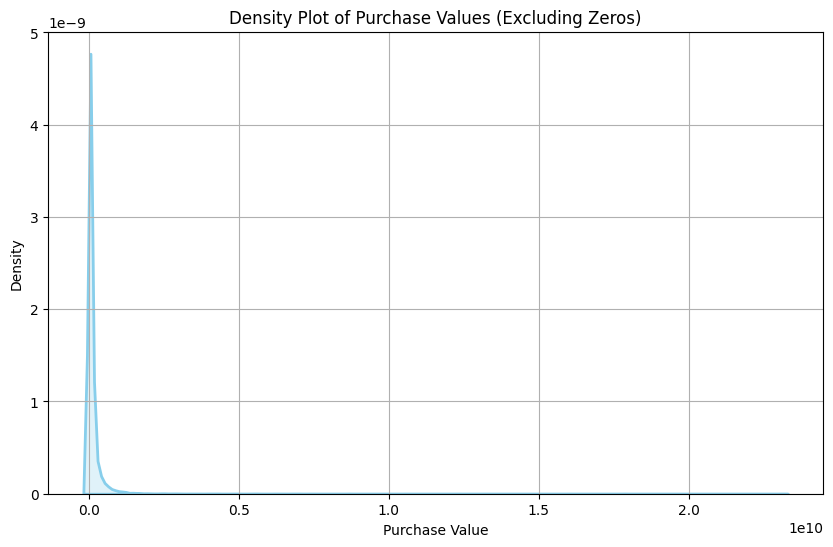

In [76]:
import seaborn as sns
non_zero_values = df[df['purchaseValue'] >0]['purchaseValue']
plt.figure(figsize=(10, 6))
sns.kdeplot(non_zero_values, fill=True, color='skyblue', linewidth=2)
plt.title('Density Plot of Purchase Values (Excluding Zeros)')
plt.xlabel('Purchase Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

We can see that most of the values are closer to 0 or even equal to 0, but there are a wide variety of values

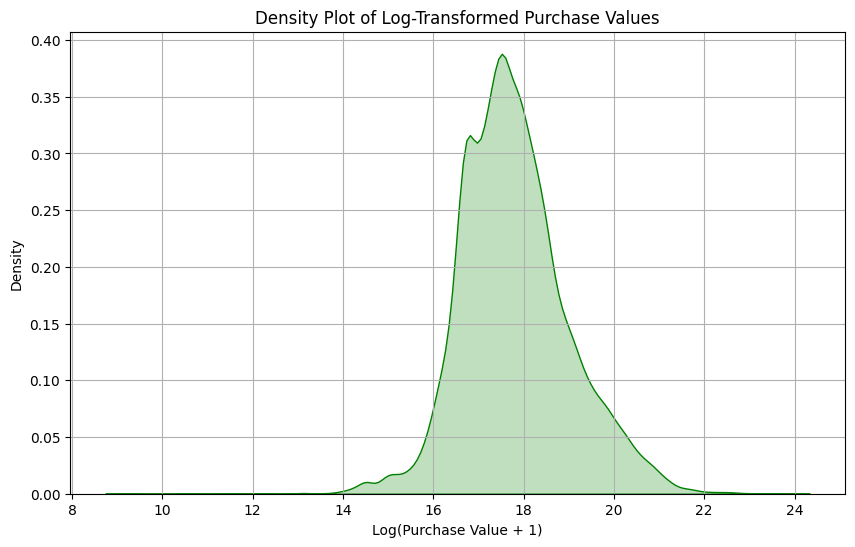

In [77]:
log_values = np.log1p(df[df['purchaseValue'] > 0]['purchaseValue'])

plt.figure(figsize=(10, 6))
sns.kdeplot(log_values, fill=True, color='green')
plt.title('Density Plot of Log-Transformed Purchase Values')
plt.xlabel('Log(Purchase Value + 1)')
plt.grid(True)
plt.show()


Log Trannsformed Density Plot gives a clear understand of how this plot is actually distributed

<Axes: >

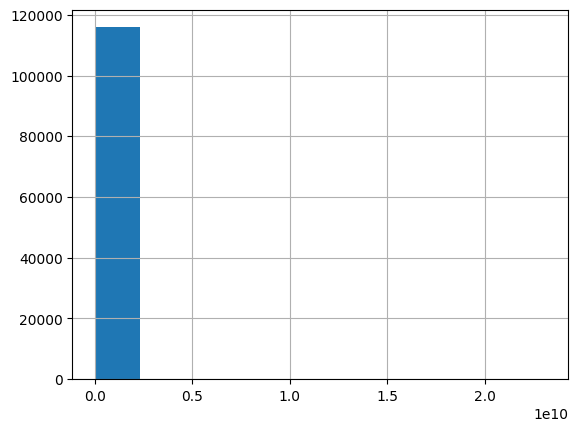

In [78]:
df['purchaseValue'].hist()

### Insight:

The target purchaseValue is highly imbalanced with very large values.

~79% of the values are 0.

The remaining are very high numbers, making this both sparse and skewed.

## Preprocessing
Castegorical Features
One hot for fewer number of columns and Frequency Encode larger value_counts (threshold value = 20)

No standard Scaling for numerical columns

In [79]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def basic_preprocessing(X_train, X_test, unique_threshold=20):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # Fill missing
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            mode_val = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(mode_val)
            X_test[col] = X_test[col].fillna(mode_val)
        else:
            mean_val = X_train[col].mean()
            X_train[col] = X_train[col].fillna(mean_val)
            X_test[col] = X_test[col].fillna(mean_val)

    # Encode
    cat_cols = X_train.select_dtypes(include='object').columns.tolist()
    low_card = [col for col in cat_cols if X_train[col].nunique() <= unique_threshold]
    high_card = [col for col in cat_cols if X_train[col].nunique() > unique_threshold]

    def frequency_encode(train, test, cols):
        for col in cols:
            freq = train[col].value_counts(normalize=True)
            train[col] = train[col].map(freq)
            test[col] = test[col].map(freq).fillna(0)
        return train, test

    X_train, X_test = frequency_encode(X_train, X_test, high_card)

    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), low_card)
    ], remainder='passthrough')

    return X_train, X_test, preprocessor


Splitting into Train and Test

In [80]:
from sklearn.model_selection import train_test_split

# Split features & target
X = df.drop('purchaseValue', axis=1)
y = df['purchaseValue']

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Preprocess
X_train_proc, X_test_proc, preprocessor = basic_preprocessing(X_train, X_test)
X_train_transformed = preprocessor.fit_transform(X_train_proc)
X_test_transformed = preprocessor.transform(X_test_proc)


#### Model Building

Model 1: Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_transformed, y_train)
y_pred_rf = rf.predict(X_test_transformed)

print("Random Forest:")
print("R2 Score:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))


Random Forest:
R2 Score: 0.20394471535498837
MSE: 3.623587376573894e+16


Model 2: HistGradientBoosting Regressor

In [82]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train_transformed, y_train)
y_pred_hgb = hgb.predict(X_test_transformed)

print("HistGradientBoosting:")
print("R2 Score:", r2_score(y_test, y_pred_hgb))
print("MSE:", mean_squared_error(y_test, y_pred_hgb))


HistGradientBoosting:
R2 Score: 0.2685214181690284
MSE: 3.329638790776782e+16


Model 3: XGBoost Regressor

In [83]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=42)
xgbr.fit(X_train_transformed, y_train)
y_pred_xgb = xgbr.predict(X_test_transformed)

print("XGBoost:")
print("R2 Score:", r2_score(y_test, y_pred_xgb))
print("MSE:", mean_squared_error(y_test, y_pred_xgb))


XGBoost:
R2 Score: 0.14448748762807706
MSE: 3.894232473708563e+16


When we try a direct Regressor model, we are not getting proper R2 Scores,

### Dual model approach

First we do Classification to predict if purchase happened or not and then do Regression to predict the actual purchase value.

Classification – to predict whether a purchase occurs (0 or not)

Regression – to predict the actual purchase amount for non-zero sessions

### Preprocessing

Preprocessing in such a way to feed to a classifier model

In [84]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def full_preprocessing(X_train, X_test, unique_threshold=20):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # Handle Missing Values
    for col in X_train.columns:
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            mode_val = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(mode_val)
            X_test[col] = X_test[col].fillna(mode_val)
        else:
            mean_val = X_train[col].mean()
            X_train[col] = X_train[col].fillna(mean_val)
            X_test[col] = X_test[col].fillna(mean_val)

    # Identify Categorical Columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    low_card_cols = [col for col in categorical_cols if X_train[col].nunique() <= unique_threshold]
    high_card_cols = [col for col in categorical_cols if X_train[col].nunique() > unique_threshold]

    # Frequency Encoding
    def frequency_encode(df_train, df_test, columns):
        for col in columns:
            freq = df_train[col].value_counts() / len(df_train)
            df_train[col] = df_train[col].map(freq)
            df_test[col] = df_test[col].map(freq).fillna(0)
        return df_train, df_test

    X_train, X_test = frequency_encode(X_train, X_test, high_card_cols)

    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols += high_card_cols  # include freq encoded

    # Define Column Transformer
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), low_card_cols)
    ], remainder='passthrough')  # no scaling

    return X_train, X_test, preprocessor


Splitting and applying preprocessing

In [85]:
from sklearn.model_selection import train_test_split

X = df.drop('purchaseValue', axis=1)
y = df['purchaseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=60)

X_train_proc, X_test_proc, preprocessor = full_preprocessing(X_train, X_test)
X_train_transformed = preprocessor.fit_transform(X_train_proc)
X_test_transformed = preprocessor.transform(X_test_proc)

#Labels for Classifier
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)


### Training Classifier

HistGradientBoosting Classifier is the best classifier among all the classifiers I tried

In [86]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score

clf=HistGradientBoostingClassifier()
clf.fit(X_train_transformed, y_train_class)
threshold = 0.75
probs = clf.predict_proba(X_test_transformed)[:, 1]
stage1_preds = (probs > threshold).astype(int)
f1_score(y_test_class,stage1_preds)

0.8793133344893358

Performing Hyper Parameter tuning for HGB Classifier

Using compute_class_weight library to handle the imbalance in the target var

In [87]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

#Weights for the imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 200],
    'max_depth': [5,7],
    'l2_regularization': [1.0]
}

clf_hpt = HistGradientBoostingClassifier(
    random_state=42,
    class_weight=class_weight_dict
)

grid = GridSearchCV(clf_hpt, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train_transformed, y_train_class)

print("Best params:", grid.best_params_)
print("Best F1 score:", grid.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 200}
Best F1 score: 0.8993497623072336


Now we get the best score for the classifier, we train the model with those parameters

In [88]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
clf = HistGradientBoostingClassifier(
    random_state=42,
    learning_rate=0.1,
    max_iter=200,
    max_depth=7,
    l2_regularization=1.0,
    class_weight=class_weight_dict
)
clf.fit(X_train_transformed, y_train_class)

threshold = 0.75
probs = clf.predict_proba(X_test_transformed)[:, 1]
stage1_preds = (probs > threshold).astype(int)

Coming to Regression of those predicted values

We do Random Forest Regressor - which overall was the best regressor (in this dual model pipeline) when I tried with other models

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Higher weight for positive purchases
weights = np.where(y_train > 0, 20, 1)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_transformed, y_train,sample_weight=weights)

# Predict only for predicted positive sessions
regression_preds = regressor.predict(X_test_transformed[stage1_preds == 1])

# Merge predictions
final_preds = np.zeros(len(X_test_transformed))
final_preds[stage1_preds == 1] = regression_preds

# Evaluate
print("Final R2 Score:", r2_score(y_test, final_preds))

Final R2 Score: 0.7207159693929517


Performing HyperParameter Tuning for Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Filter only positive purchase sessions for training
mask_train = y_train > 0
X_train_pos = X_train_transformed[mask_train]
y_train_pos = y_train[mask_train]
weights_pos = np.where(y_train_pos > 0, 20, 1)  # same logic

# Grid Search params
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
}

reg = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=2,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_pos, y_train_pos, sample_weight=weights_pos)

best_rf = grid.best_estimator_

# Predict only for predicted positive sessions in test
regression_preds = best_rf.predict(X_test_transformed[stage1_preds == 1])

# Merge predictions
final_preds = np.zeros(len(X_test_transformed))
final_preds[stage1_preds == 1] = regression_preds

# Evaluate
from sklearn.metrics import r2_score
print("Final R2 Score on Full Test Set:", r2_score(y_test, final_preds))


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Final R2 Score on Full Test Set: 0.7081742871531868


We can notice there is poor performance when we do hyper parameter tuning for random forest, so we just pass the actual model with all default hyper parameters (as before) for better performance

In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Higher weight for positive purchases
weights = np.where(y_train > 0, 20, 1)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_transformed, y_train,sample_weight=weights)

# Predict only for predicted positive sessions
regression_preds = regressor.predict(X_test_transformed[stage1_preds == 1])

# Merge predictions
final_preds = np.zeros(len(X_test_transformed))
final_preds[stage1_preds == 1] = regression_preds

# Evaluate
print("Final R2 Score:", r2_score(y_test, final_preds))

Final R2 Score: 0.7207159693929517


The Final R2 Score with all default hyper parameters in random forest model

In [92]:
from sklearn.metrics import r2_score

# Train R² (regression only on y_train > 0)
train_mask = y_train > 0
reg_train_preds = regressor.predict(X_train_transformed[train_mask])
train_r2 = r2_score(y_train[train_mask], reg_train_preds)
print("Train R²:", train_r2)

# Test R²
test_mask = stage1_preds == 1
reg_test_preds = regressor.predict(X_test_transformed[test_mask])
test_r2 = r2_score(y_test[test_mask], reg_test_preds)
print("Test R²:", test_r2)


Train R²: 0.8888374873133071
Test R²: 0.7101170945102137


This is the highest R2 for both train adn test I got, which explains least overfitting of the model

Other different models gave better training score but very low testing score, so that lead to overfitting of the model.

In [93]:
X_dft = dft.copy()

_, X_dft_proc, _ = full_preprocessing(X_train.copy(), X_dft.copy(), unique_threshold=20)

X_dft_transformed = preprocessor.transform(X_dft_proc)

probs_dft = clf.predict_proba(X_dft_transformed)[:, 1]
stage1_preds = (probs_dft > threshold).astype(int)

regression_preds = regressor.predict(X_dft_transformed[stage1_preds == 1])

final_preds = np.zeros(len(X_dft_transformed))
final_preds[stage1_preds == 1] = regression_preds

submission = pd.DataFrame({
    'id': range(len(final_preds)),
    'purchaseValue': final_preds
})

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created successfully.")


✅ submission.csv created successfully.


This is the final submission file for the test dataset given for the competition.

Preprocessing dft (test df) and applying these models, and predicting the values for final submission.csv file